# Periodic discrete functions

In practice, of course, we cannot manipulate infinite grid functions numerically. The next best thing is to assume periodicity in space. We will assume $u(x)$ is $2\pi$-periodic and discretize it over $(0,2\pi]:$

$$
x_i = ih, \qquad h = \frac{2\pi}{N}, \qquad i=1,\ldots,N. 
$$

We let $v_i=u(x_i)$ and, when convenient, allow $v$ to be extended periodically by assuming $v_{j+mN}=v_j$ for all integers $j$ and $m$. 

```{caution}
We assume throughout that $N$ is even. The formulas for odd $N$ are usually different.
```

## Discrete Fourier transform

Previously, discretization of the function $u$ on the whole real line caused its transform to be confined to $k \in (-\pi/h,\pi/h]$. Now, confining the function to $[0,2\pi]$ also causes $k$ to be discretized. Since $\pi/h=N/2$, in fact, we have

$$
k \in \left\{ -\frac{N}{2}+1,-\frac{N}{2}+2,\ldots,\frac{N}{2} \right\}. 
$$


::::{prf:definition} Discrete Fourier transform
The **discrete Fourier transform** of a discretized, periodic function $v_j$ is 

$$
\mathcal{F}_N[u](k) = \hat{v}_k = h \sum_{j=1}^N e^{-ikx_j}\, v_j, \qquad  k = -\tfrac{N}{2}+1,-\frac{N}{2}+2,\ldots,\tfrac{N}{2}. 
$$

Its inverse is

$$
v_j = \frac{1}{2\pi} \sum_{k=1-(N/2)}^{N/2} e^{ikx_j}\, \hat{v}_k, \qquad  j=1,\ldots,N. 
$$
::::

## Sawtooth mode

The inverse transform formula above has an asymmetry with respect to the mode at 

$$
k = \pm \frac{\pi}{h} = \pm \frac{N}{2}. 
$$

(These are equivalent wavenumbers on the grid, by aliasing.) This is called the **sawtooth** Fourier mode, because

$$
\exp\left[ i \frac{N}{2} x_j \right] = \exp\left[ i \frac{\pi}{h} (jh) \right] = (-1)^j,
$$

i.e., the sawtooth mode toggles between $1$ and $-1$ on the grid. 

The inverse transform as given above puts all the content in $k=+N/2$, which is fine for the transform itself, but implies a complex derivative $\pm (iN/2)$ on the grid that is not in keeping with what the sawtooth itself suggests. 

The remedy is to split the content in the sawtooth mode evenly between the equivalent wavenumbers:

$$
v_j = \frac{1}{2\pi} \sideset{}{'}\sum_{k=-N/2}^{N/2} e^{ikx_j}\, \hat{v}_k, \qquad  j=1,\ldots,N,
$$

where the prime on the sum means to apply a factor of $1/2$ to the first and last terms. For the transform itself, this makes no change, but at the sawtooth mode, we now differentiate 

$$
\frac{1}{2}\left( e^{iNx/2} + e^{-iNx/2} \right) = \cos\left(\frac{Nx}{2}\right), 
$$

which has derivative zero on the grid.

Before leaving this subject, we point out that the situation above arises only for odd-numbered derivatives. For an even derivative, both forms of the sawtooth yield the same (real) values on the grid, and either form of the transform can be used for band-limited interpolation.

## Differentiation matrix

The band-limited interpolant is now 

$$
p(x) = \frac{1}{2\pi} \sideset{}{'}\sum_{k=-N/2}^{N/2} e^{ikx}\, \hat{v}_k,
$$

for $x\in(0,2\pi]$. As always, we can differentiate this interpolant and evaluate it on the grid. But to derive a column of the differentiation matrix, we only need to apply the process to the discrete periodic $\delta$, where $d_j=1$ for all $j=mN$ and $d_j=0$ otherwise. The resulting $p$ is the periodic version of the sinc function:

$$
S_N(x) = \frac{\sin(\pi x/h)}{(2\pi/h)\tan(x/2)},
$$

which interpolates the discrete delta while also being $2\pi$-periodic. The entries of column 0 in the differentiation matrix $\bfD_N$ are

$$
S'_N(x_j) = \begin{cases}
  0, & j=0 (\mod N), \\ 
  \tfrac{1}{2}(-1)^j\cot({jh}/2), & j \neq 0 (\mod N).
  \end{cases}
$$

Naturally, column 0 is the same as column $N$, and the rest of the columns are shifted versions of it. The result is again a circulant matrix.

In [1]:
using Sugar, SpectralMethodsTrefethen
Sugar.get_source(first(methods(p4))) |> last |> print

function p4()
    # Set up grid and differentiation matrix:
    N = 24
    h = 2π / N
    x = h * (1:N)
    column = [0; @. 0.5 * (-1)^(1:N-1) * cot((1:N-1) * h / 2)]
    D = toeplitz(column, column[[1; N:-1:2]])

    # Differentiation of a hat function:
    v = @. max(0, 1 - abs(x - π) / 2)
    clf()
    subplot(2, 2, 1)
    plot(x, v, ".-", markersize=6)
    axis([0, 2π, -0.5, 1.5])
    grid(true)
    title("function")
    subplot(2, 2, 2), plot(x, D * v, ".-", markersize=6)
    axis([0, 2π, -1, 1])
    grid(true)
    title("spectral derivative")

    # Differentiation of exp(sin(x)):
    v = @. exp(sin(x))
    vʹ = @. cos(x) * v
    subplot(2, 2, 3), plot(x, v, ".-", markersize=6)
    axis([0, 2π, 0, 3]), grid(true)
    subplot(2, 2, 4), plot(x, D * v, ".-", markersize=6)
    axis([0, 2π, -2, 2]), grid(true)
    error = round(norm(D * v - vʹ, Inf), sigdigits=5)
    text(2.2, 1.4, "max error = $error", fontsize=8)
    return gcf()
end

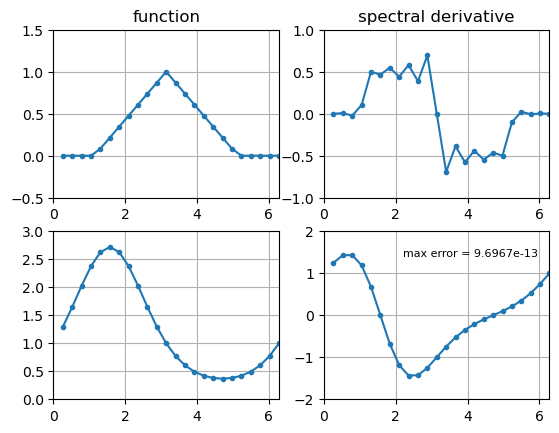

In [2]:
p4();

The differentiation of the nonsmooth function is very poor, but for the smooth case, it's very accurate.

As before, we can differentiate $S_N$ twice to get a differentiation matrix for the second derivative. (See textbook.)

## FFT

In the previous section, we observed that one can operate in wavenumber space rather than physical space in order to compute the derivative of a grid function. The same applies in the periodic context:

1. Set $\hat{w}_k = i k\, \hat{v}(k)$, except $\hat{w}_{N/2}=0$.
2. Let $w = \mathcal{F}_N^{-1}[\hat{w}]$. 

For the $v$th derivative, the factor in passing from $\hat{v}$ to $\hat{w}$ is $(ik)^\nu$, except it must be set to zero if $v$ is odd.

This pathway becomes acutely relevant because of the **Fast Fourier Transform**, credited to Cooley and Tukey in modern times but going back to Gauss. The FFT allows computation of the DFT and IDFT in $O(N\log N)$ operations, versus the $O(N^2)$ of a naive DFT implementation as well as for matrix-vector multiplication in physical space. Asymptotically, the FFT pathway should be the fastest by far, although the $N$ at which it begins to have an advantage is often larger than one wants to use in practice anyway.

In [3]:
Sugar.get_source(first(methods(p5))) |> last |> print

function p5()
    #        For complex v, delete "real" commands.
    # Differentiation of a hat function:
    N = 24
    h = 2π / N
    x = h * (1:N)
    v = @. max(0, 1 - abs(x - π) / 2)
    v̂ = fft(v)
    ŵ = 1im * [0:N/2-1; 0; -N/2+1:-1] .* v̂
    w = real(ifft(ŵ))
    clf()
    subplot(2, 2, 1)
    plot(x, v, ".-", markersize=6)
    axis([0, 2π, -0.5, 1.5])
    grid(true)
    title("function")
    subplot(2, 2, 2), plot(x, w, ".-", markersize=6)
    axis([0, 2π, -1, 1])
    grid(true)
    title("spectral derivative")

    # Differentiation of exp(sin(x)):
    v = @. exp(sin(x))
    vʹ = @. cos(x) * v
    v̂ = fft(v)
    ŵ = 1im * [0:N/2-1; 0; -N/2+1:-1] .* v̂
    w = real(ifft(ŵ))
    subplot(2, 2, 3), plot(x, v, ".-", markersize=6)
    axis([0, 2π, 0, 3]), grid(true)
    subplot(2, 2, 4), plot(x, w, ".-", markersize=6)
    axis([0, 2π, -2, 2]), grid(true)
    error = round(norm(w - vʹ, Inf), sigdigits=4)
    text(2.2, 1.4, "max error = $error", fontsize=8)
    return gcf()
e

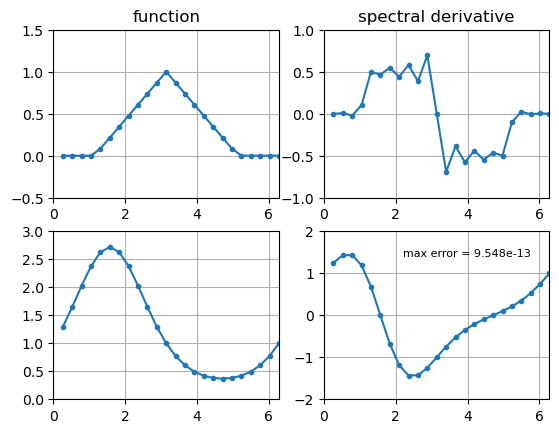

In [4]:
p5();

There is some inefficiency in the use of the FFT above. When the original function is real, its transform has conjugate symmetry, and the transform can be simplified to find only the first half of the transform. Julia exposes this special form of the FFT for you to exploit:

In [5]:
Sugar.get_source(first(methods(p5r))) |> last |> print

function p5r()
    #        For complex v, delete "real" commands.
    # Differentiation of a hat function:
    N = 24
    h = 2π / N
    x = h * (1:N)
    v = @. max(0, 1 - abs(x - π) / 2)
    v̂ = rfft(v)
    ŵ = 1im * [0:N/2-1; 0] .* v̂
    w = irfft(ŵ,N)
    clf()
    subplot(2, 2, 1)
    plot(x, v, ".-", markersize=6)
    axis([0, 2π, -0.5, 1.5])
    grid(true)
    title("function")
    subplot(2, 2, 2), plot(x, w, ".-", markersize=6)
    axis([0, 2π, -1, 1])
    grid(true)
    title("spectral derivative")

    # Differentiation of exp(sin(x)):
    v = @. exp(sin(x))
    vʹ = @. cos(x) * v
    v̂ = rfft(v)
    ŵ = 1im * [0:N/2-1; 0] .* v̂
    w = irfft(ŵ,N)
    subplot(2, 2, 3), plot(x, v, ".-", markersize=6)
    axis([0, 2π, 0, 3]), grid(true)
    subplot(2, 2, 4), plot(x, w, ".-", markersize=6)
    axis([0, 2π, -2, 2]), grid(true)
    error = round(norm(w - vʹ, Inf), sigdigits=4)
    text(2.2, 1.4, "max error = $error", fontsize=8)
    return gcf()
end

## Method of lines

Here is a solution of the variable-coefficient advection PDE

$$
\partial_t u + c(x) \partial_x u = 0, \qquad c(x) = \frac{1}{5} + \sin^2(x-1). 
$$

Note that the velocity is $2\pi$-periodic, which is required for periodic boundary conditions to work as intended. 

This function applies the midpoint/leapfrog method in time, with FFT-based spectral differentiation in space:

In [6]:
Sugar.get_source(first(methods(p6))) |> last |> print

function p6()
    # Grid, variable coefficient, and initial data:
    N = 128
    h = 2π / N
    x = h * (1:N)
    t = 0
    Δt = h / 4
    c = @. 0.2 + sin(x - 1)^2
    v = @. exp(-100 * (x - 1) .^ 2)
    vold = @. exp(-100 * (x - 0.2Δt - 1) .^ 2)

    # Time-stepping by leap frog formula:
    tmax = 8
    tplot = 0.15
    clf()
    plotgap = round(tplot / Δt)
    Δt = tplot / plotgap
    nplots = round(Int, tmax / tplot)
    data = [v zeros(N, nplots)]
    tdata = [t]
    for i in 1:nplots
        for n in 1:plotgap
            t = t + Δt
            v̂ = rfft(v)
            ŵ = 1im * [0:N/2-1; 0] .* v̂
            w = irfft(ŵ,N)
            vnew = vold - 2Δt * c .* w
            vold = v
            v = vnew
        end
        data[:, i+1] = v
        tdata = [tdata; t]
    end
    mesh(x, tdata, data', ccount=0)
    view(10, 70)
    xlim(0, 2π)
    ylim(0, tmax)
    zlim(0, 5)
    xlabel("x")
    ylabel("t")
    zlabel("u")
    return gcf()
end

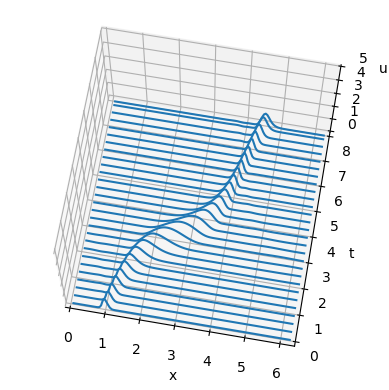

In [7]:
p6();

It's worth considering the absolute stability restriction that is implied by the spectral differentiation. First, we note that the stability region of the leapfrog scheme is $[-i,i]$ on the imaginary axis. 

Multiplication by the DM in physical space is equivalent to operating in Fourier space, as described earlier. But in Fourier space, the operation is diagonal: $\hat{w}_k = g(k) \hat{v}_k$, where $g(k)=ik$ except for zero at the sawtooth mode. What this shows is that the discretized Fourier modes actually diagonalize the DM (which turns out to be true for any circulant matrix), and the eigenvalues are the discrete values of $g(k)$:

$$
\lambda_k = ik, \qquad k=1-\tfrac{N}{2},\dots,\tfrac{N}{2}-1. 
$$ 

The tricky bit in this example is the pointwise multiplication of $\partial_x u$ by $c(x)$, which corresponds to left-multiplication of $\bfD_x$ by a diagonal matrix. It's hard to say precisely what happens to the eigenvalues, but as an estimate, we should suppose that they are scaled by no more than the maximum value of $c$, which is $6/5$. The consequent stability restriction is

$$
\tfrac{6}{5} \tau \left(\tfrac{N}{2}-1 \right) \le 1,
$$

or roughly $\tau \le 5/3N$. This is a bit pessimistic; as shown in the next figure, the critical value appears to be closer to 1.9 than 1.67:

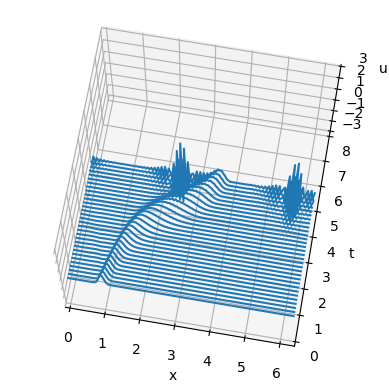

In [8]:
p6u();